# **BIG CASE XP** - FLORENCE RAMANUJAN


**Vitor Toni Docampo** - https://www.linkedin.com/in/vitortoni/ <br>
Repositório - https://github.com/VitorToni/Case_XP

Feito no Google Colab

# > Subindo Ambiente



```
# Caso precise criar o ambinete selecionando as dependências

!apt update # Atualiza a lista de pacotes disponíveis
!apt-get install openjdk-8-jdk-headless > /dev/null # instalando Java na versão desejada
!wget https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz # Baixa Spark
!wget https://archive.apache.org/dist/hadoop/core/hadoop-3.2.1/hadoop-3.2.1.tar.gz # Baixa Hadoop
!tar -xzf spark-3.2.0-bin-hadoop3.2.tgz # Extrai Spark
!tar -xzf hadoop-3.2.1.tar.gz # Extrai Hadoop
!rm -rf spark-3.2.0-bin-hadoop3.2.tgz # Remove spark
!rm -rf hadoop-3.2.1.tar.gz # Remove hadoop

!pip install -q findspark # Instala o findspark

import os # Definindo os caminhos
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"
os.environ['HADOOP_HOME'] = '/content/hadoop-3.2.1'
os.environ['HIVE_HOME'] = '/content/hive'

import findspark
findspark.init('/content/spark-3.2.0-bin-hadoop3.2') # Permite que o Python encontre as bibliotecas do Spark, tornando "importável"
```



In [ ]:
!pip install pyspark

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkFiles
import pandas as pd
import scipy
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import display
import random
import requests
from tqdm import tqdm
from google.colab import output
output.enable_custom_widget_manager()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=f5c516b560a4cead327f134dd782d3f0829b6c65b02a16570efa6f9df1842972
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
# Cria sessão com o Spark

spark = SparkSession.builder\
          .master("local")\
          .appName("Case_XP")\
          .config("spark.sql.hive.convertMetastoreOrc", "true")\
          .enableHiveSupport()\
          .getOrCreate()

# .config("spark.sql.hive.convertMetastoreOrc", "true") Habilita o suporte do Spark para usar o metastore do Hive com arquivos ORC
# .enableHiveSupport() Ativa o suporte ao Hive no Spark para a execução de comandos SQL compatíveis com o Hive

# > Construção da Base

**Extract**

In [ ]:
# Utilizando list comprehension para subir todos CSV's do repositório Github para pyspark.sql.dataframe

response = requests.get("https://api.github.com/repos/VitorToni/Case_XP/contents/Dados")
if response.status_code == 200: # sucesso
    itens = response.json()
    csv_files = [item for item in itens if item['type'] == "file" and item['name'].endswith(".csv")]
    for idx, file in tqdm(enumerate(csv_files), total=len(csv_files), desc='Transformando CSV\'s em PySpark DF'):
        spark.sparkContext.addFile(file['download_url'])
        exec(f"{file['name'][2:-4]} = spark.read.csv(SparkFiles.get(\"{file['name']}\"), inferSchema = True, header = True)")

Transformando CSV's em PySpark DF: 100%|██████████| 6/6 [00:19<00:00,  3.20s/it]


**Transform**

In [ ]:
# Trabalhando com as bases, inserindo os dados categóricos, criando colunas necessárias, consolidando e salvando o output:

captacao_safrada = captacao.join(conta, on="COD_CONTA", how="left")\
                           .join(assessor, on="COD_ASSESSOR", how="left")\
                           .join(tipo_movimento, on="COD_TIPO_MOVIMENTO", how="left")\
                           .withColumn("VALOR_DIA", col("VAL_MOVIMENTO").cast("decimal(18,2)"))\
                           .withColumn("ANOMES", date_format(to_date(captacao["COD_DIM_TEMPO"].cast("string"), "yyyyMMdd"), "yyyyMM"))\
                           .withColumn("FATO", lit("Captação Líquida"))\
                           .withColumn("CATEGORIA_PRODUTO", lit("Não se aplica"))\
                           .select("FATO", "COD_CONTA", "DSC_SUITABILITY", "COD_ASSESSOR", "DSC_SITUACAO", "ANOMES", "DSC_TIPO_MOVIMENTO", "CATEGORIA_PRODUTO", "VALOR_DIA")
                           # Lit cria colunas com valores estáticos no DF

custodia_safrada = custodia.join(conta, on="COD_CONTA", how="left")\
                           .join(assessor, on="COD_ASSESSOR", how="left")\
                           .join(produto, on="COD_PRODUTO", how="left")\
                           .withColumn("VALOR_DIA", col("VAL_POSICAO").cast("decimal(18,2)"))\
                           .withColumn("ANOMES", date_format(to_date(custodia["COD_DIM_TEMPO"].cast("string"), "yyyyMMdd"), "yyyyMM"))\
                           .withColumn("FATO", lit("Custódia"))\
                           .withColumn("DSC_TIPO_MOVIMENTO", lit("Não se aplica"))\
                           .select("FATO", "COD_CONTA", "DSC_SUITABILITY", "COD_ASSESSOR", "DSC_SITUACAO", "ANOMES", "DSC_TIPO_MOVIMENTO", "CATEGORIA_PRODUTO", "VALOR_DIA")

# Poderia renomear e selecionar as colunas usando um loop, porém achei o número pequeno e apenas complicaria o entendimento do processo
# Sumarizando o VAL_MOVIMENTO e VAL_POSICAO pois a referencia é diária, agora a visão safrada está finalizada
Carteira_Safrada = captacao_safrada.union(custodia_safrada)\
 .withColumnRenamed("COD_CONTA", "CONTA")\
 .withColumnRenamed("DSC_SUITABILITY", "SUITABILITY")\
 .withColumnRenamed("COD_ASSESSOR", "ASSESSOR")\
 .withColumnRenamed("DSC_SITUACAO", "SITUACAO")\
 .withColumnRenamed("DSC_TIPO_MOVIMENTO", "TIPOMOVIMENTO")\
 .withColumnRenamed("CATEGORIA_PRODUTO", "CATEGPROD")\
 .groupBy("FATO", "CONTA", "SUITABILITY", "ASSESSOR", "SITUACAO", "ANOMES", "TIPOMOVIMENTO", "CATEGPROD")\
 .sum("VALOR_DIA")\
 .withColumn("VALOR", col("sum(VALOR_DIA)").cast("decimal(18,2)"))\
 .select("FATO", "CONTA", "SUITABILITY", "ASSESSOR", "SITUACAO", "ANOMES", "TIPOMOVIMENTO", "CATEGPROD", "VALOR")

**Load**

In [ ]:
# Cria a tabela apenas caso não exista, e não é necessário fornecer informações sobre as partições, 
# o arquivo previamente salvo desta forma.

Carteira_Safrada.write.partitionBy("ANOMES")\
   .format("orc").option("compression", "snappy")\
   .mode("overwrite").option("mode", "ignore")\
   .save("/content/Lake_Florence_Ramanujan/DL_Carteira_Safrada")

spark.sql("""
    CREATE TABLE IF NOT EXISTS DL_Carteira_Safrada (
        FATO STRING COMMENT 'Tipo operacao',
        CONTA STRING COMMENT 'Codigo da conta do cliente',
        SUITABILITY STRING COMMENT 'Perfil de investidor do cliente',
        ASSESSOR STRING COMMENT 'Codigo do assessor para a respectiva conta quando o fato ocorreu',
        SITUACAO STRING COMMENT 'Representa se o assessor esta ativo ou inativo',
        ANOMES INTEGER COMMENT 'Safra das operacoes',
        TIPOMOVIMENTO STRING COMMENT 'Categoriza o fluxo de caixa que entrou ou saiu (Captacao Liquida)',
        CATEGPROD STRING COMMENT 'Categoriza os ativos financeiros (Custodia)',
        VALOR DECIMAL(18,2) COMMENT 'Valor do montante de Custodia ou Captacao Liquida no periodo'
    )
    COMMENT 'Tabela da carteira safrada em uma unica dimensao'
    PARTITIONED BY (ANOMES)
    STORED AS ORC 
    TBLPROPERTIES ("orc.compress"="SNAPPY")
    LOCATION '/content/Lake_Florence_Ramanujan/DL_Carteira_Safrada'
""")
spark.sql("MSCK REPAIR TABLE DL_Carteira_Safrada")
# Atualiza os metadados e garante que o Spark reconheça as partições e acesse os dados correspondentes.

DataFrame[]

In [ ]:
# Caso precise excluir para reprocessar:
# !rm -rf /content/Lake_Florence_Ramanujan
# !rm -rf /content/metastore_db
# !rm -rf /content/derby.log



> Salvando em uma Tabela Particionada por SAFRA, no formato ORC e comprimido com SNAPPY.<br>
> <br>Melhora as consultas que usam o ANOMES como filtro. <br>
> <br>ORC é em formato colunar, facilitanto leitura para insights, já o PARQUET seria melhor para leituras completas da Tabela. <br>
> <br>SNAPPY reduz o tamanho de cada arquivo armazenado e alta taxa de descompressão. <br>

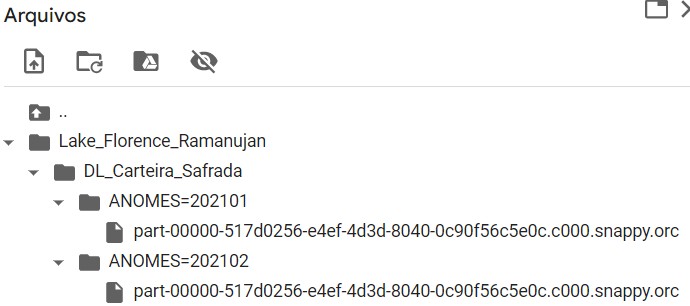

```
# Códigos para checar o Schema e todoas partições
spark.table("Base_Clientes").printSchema()
spark.sql("show partitions Base_Clientes").show()
```

In [ ]:
spark.sql("describe extended DL_Carteira_Safrada").show(50,truncate=False)

+----------------------------+---------------------------------------------------------+-----------------------------------------------------------------+
|col_name                    |data_type                                                |comment                                                          |
+----------------------------+---------------------------------------------------------+-----------------------------------------------------------------+
|FATO                        |string                                                   |Tipo operacao                                                    |
|CONTA                       |string                                                   |Codigo da conta do cliente                                       |
|SUITABILITY                 |string                                                   |Perfil de investidor do cliente                                  |
|ASSESSOR                    |string                                  

**Remarcação das carteiras**

In [ ]:
# Função útil para subtrair ou adicionar meses ao ANOMES parametrizado

def C_safra(anomes: int, months: int) -> str:
    data = datetime.strptime(str(anomes), "%Y%m")
    data = data + relativedelta(months=+months)
    return datetime.strftime(data, "%Y%m")


# Armazena a safra mais recente em um variável

max_anomes = Carteira_Safrada.agg(max("anomes")).collect()[0][0]

In [ ]:
# Extrai todos os números de Conta da ultima carteira pertencente a Florence
contas_df = spark.sql(f"""
  select distinct CONTA, ASSESSOR as ASSESSOR_FLORENCE
  from DL_Carteira_Safrada 
  where ASSESSOR = 568 and ANOMES = {max_anomes}
""")

# Seleciona público para comparação e teste
valid_conta = Carteira_Safrada.select("CONTA", "ASSESSOR").join(contas_df, "CONTA", "left_outer")\
              .filter(col("ASSESSOR_FLORENCE").isNotNull() & (col("ASSESSOR_FLORENCE") != col("ASSESSOR")))\
              .select("CONTA").limit(5)

# ReAssessorando
Carteira_Safrada = Carteira_Safrada.join(contas_df, on="CONTA", how="left")\
    .withColumn("ASSESSOR", coalesce("ASSESSOR_FLORENCE", "ASSESSOR"))\
    .withColumn("ASSESSOR", when(col("ASSESSOR") == 568, "FLORENCE").otherwise("DEMAIS"))

# Seleciona um caso que mudou de Assessor
aux = valid_conta.limit(1).collect()[0]["CONTA"]

# Busca no Lake
spark.sql(f"""
  select distinct ANOMES, CONTA, ASSESSOR
  from DL_Carteira_Safrada 
  where CONTA = {aux}
  order by ANOMES
""").show()

# Compara e valida a mudança
Carteira_Safrada.filter(col("CONTA") == aux) \
    .select("ANOMES", "CONTA", "ASSESSOR") \
    .distinct() \
    .orderBy("ANOMES").show()

+------+-----+--------+
|ANOMES|CONTA|ASSESSOR|
+------+-----+--------+
|202101| 4051|     231|
|202102| 4051|     231|
|202103| 4051|     231|
|202104| 4051|     231|
|202105| 4051|     231|
|202106| 4051|     231|
|202107| 4051|     231|
|202108| 4051|     568|
|202109| 4051|     568|
|202110| 4051|     568|
|202111| 4051|     568|
|202112| 4051|     568|
+------+-----+--------+

+------+-----+--------+
|ANOMES|CONTA|ASSESSOR|
+------+-----+--------+
|202101| 4051|FLORENCE|
|202102| 4051|FLORENCE|
|202103| 4051|FLORENCE|
|202104| 4051|FLORENCE|
|202105| 4051|FLORENCE|
|202106| 4051|FLORENCE|
|202107| 4051|FLORENCE|
|202108| 4051|FLORENCE|
|202109| 4051|FLORENCE|
|202110| 4051|FLORENCE|
|202111| 4051|FLORENCE|
|202112| 4051|FLORENCE|
+------+-----+--------+



# > Análise dos Dados

**Análise Exploratória**



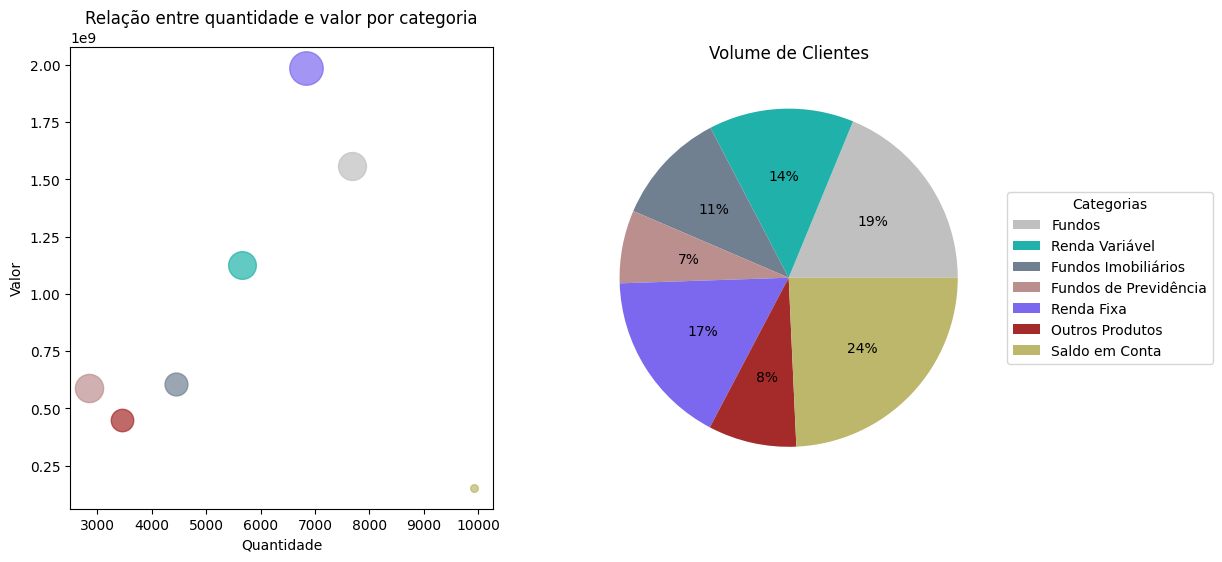

In [ ]:
df_agg = Carteira_Safrada.filter((col("FATO") == "Custódia") & (col("ANOMES") == max_anomes))\
          .groupBy('CATEGPROD')\
          .agg(sum('VALOR').alias('VALOR'), 
               count('CONTA').alias('QTD'), 
               (sum('VALOR') / count('CONTA')).alias('TICKET MEDIO'))\
          .withColumn('VALOR', col('VALOR').cast(IntegerType()))\
          .withColumn('QTD', col('QTD').cast(IntegerType()))\
          .withColumn('TICKET MEDIO', col('TICKET MEDIO').cast(IntegerType()))


# Obtém os valores em LISTA para os eixos x, y e tamanho das bolinhas (s)
x = df_agg.select('VALOR').rdd.flatMap(lambda x: x).collect()
y = df_agg.select('QTD').rdd.flatMap(lambda x: x).collect()
s = df_agg.select('TICKET MEDIO').rdd.flatMap(lambda x: x).collect()
categorias = df_agg.select('CATEGPROD').rdd.flatMap(lambda x: x).collect()

# Define a paleta de cores aleatória e automatizada
colors = random.sample(list(mcolors.CSS4_COLORS.values()), df_agg.count())

# Cria a figura com os subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plota o gráfico de dispersão no primeiro subplot
for i, cat in enumerate(df_agg.select('CATEGPROD').rdd.flatMap(lambda x: x).collect()):
    ax1.scatter(y[i], x[i], color=colors[i], label=cat, s=s[i] / 500, alpha=0.7)

ax1.set_xlabel('Quantidade')
ax1.set_ylabel('Valor')
ax1.set_title('Relação entre quantidade e valor por categoria')

# Plota o gráfico de pizza no segundo subplot
wedges, texts, autotexts = ax2.pie(y, colors=colors, autopct='%1.0f%%')
ax2.set_title('Volume de Clientes')

# Ajusta a posição da legenda
ax2.legend(wedges, categorias, title='Categorias', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

# Mostra a figura com os subplots
plt.show()

> Compreendendo a dispersão de acordo com o volume, valor e ticket médio da nossa carteira

# > Clientes que precisam de atenção:



In [ ]:
# Transpondo o DF para trabalhar de forma mais simples com as Safras

Carteira_Safrada_pivot = Carteira_Safrada.groupBy("FATO", "CONTA", "SUITABILITY", "ASSESSOR", "SITUACAO", "TIPOMOVIMENTO", "CATEGPROD")\
  .pivot("ANOMES")\
  .agg(sum("VALOR"))
  
Carteira_Safrada_pivot.show(3)

+----------------+-----+-----------+--------+--------+-------------+-------------+-------+------+-------+-------+---------+---------+---------+---------+---------+---------+---------+---------+
|            FATO|CONTA|SUITABILITY|ASSESSOR|SITUACAO|TIPOMOVIMENTO|    CATEGPROD| 202101|202102| 202103| 202104|   202105|   202106|   202107|   202108|   202109|   202110|   202111|   202112|
+----------------+-----+-----------+--------+--------+-------------+-------------+-------+------+-------+-------+---------+---------+---------+---------+---------+---------+---------+---------+
|Captação Líquida| 3182|   MODERADO|  DEMAIS|   Ativo|       EX-TED|Não se aplica|1000.00|  null|   null|   null|     null|     null|     null|  2000.00|     null|     null|     null|     null|
|        Custódia| 9002|  AGRESSIVO|  DEMAIS|   Ativo|Não se aplica|   Renda Fixa|   null|  null|   null|   null|392964.34|399038.87|446496.64|484541.76|482748.79|490448.21|487701.57|486712.60|
|        Custódia| 8691|   MOD

In [ ]:
Carteira_Safrada_pivot\
  .withColumn("Variacao1", (col(C_safra(max_anomes, -1)) / col(C_safra(max_anomes, -2)) - 1) * 100)\
  .withColumn("Variacao2", (col(max_anomes) / col(C_safra(max_anomes, -1)) - 1) * 100)\
  .filter((abs(col(max_anomes)) > 0)
         & (abs(col(C_safra(max_anomes, -1))) > 0)
         & (abs(col(C_safra(max_anomes, -2))) > 0)
         & (col("ASSESSOR") == "FLORENCE")
         & (col("CATEGPROD").isin(["Outros Produtos", "Saldo em Conta"]) == False)
         & (col("FATO") == "Custódia"))\
  .withColumn("RANK", rank().over(Window.orderBy("Variacao2", "Variacao1")))\
  .filter(col("RANK") <= 5)\
  .select("RANK", "CONTA", "SUITABILITY", "CATEGPROD", C_safra(max_anomes, -2), C_safra(max_anomes, -1), format_number("Variacao1", 2).alias("Variacao1"), max_anomes, format_number("Variacao2", 2).alias("Variacao2"))\
  .show()

+----+-----+-----------+-------------------+---------+---------+---------+--------+---------+
|RANK|CONTA|SUITABILITY|          CATEGPROD|   202110|   202111|Variacao1|  202112|Variacao2|
+----+-----+-----------+-------------------+---------+---------+---------+--------+---------+
|   1| 7307|  AGRESSIVO|     Renda Variável| 38340.90| 42009.11|     9.57| 7135.41|   -83.01|
|   2| 9297|   MODERADO|             Fundos|280579.28|277326.39|    -1.16|72815.83|   -73.74|
|   3| 1473|CONSERVADOR|         Renda Fixa|193601.88|143298.85|   -25.98|37749.24|   -73.66|
|   4| 9297|   MODERADO|Fundos Imobiliários| 81186.00| 75990.00|    -6.40|21000.00|   -72.36|
|   5| 6288|  AGRESSIVO|     Renda Variável| 50960.00| 13281.70|   -73.94| 4134.00|   -68.87|
+----+-----+-----------+-------------------+---------+---------+---------+--------+---------+



> Analisando a foto das últimas três carteiras, identificamos que há clientes com a performance abaixo do esperado <br>
> <br>Embora possuam outros movimentos/produtos, esses não justificam o observado. <br>
> <br>Podemos considerar o perfil "Agressivo" no produto "Renda Variável" como um indicador relevante e realizar análises específicas em relação a este cluster e em paralelo, ações/analises pontuais com os clientes listados acima.<br>

# > Resultado da Carteira:

In [ ]:
aux = Carteira_Safrada.filter(col("FATO") == "Custódia") \
                        .groupBy('SUITABILITY') \
                        .agg(count('CONTA').alias('QTD'))\
                        .withColumn('PCT', expr('QTD / sum(QTD) over () * 100'))

print(f'O percentual de SUITABILITY = "NÃO INFORMADO"\
 em relação ao total é {aux.filter(col("SUITABILITY") == "NÃO INFORMADO").select("PCT").first()[0]:.2f}%,\
 portanto irei ignora-lo.')

O percentual de SUITABILITY = "NÃO INFORMADO" em relação ao total é 0.25%, portanto irei ignora-lo.


In [ ]:
base_inp = Carteira_Safrada.filter((col("FATO") == "Custódia") & (col("SUITABILITY") != "NÃO INFORMADO")) \
    .groupBy('SUITABILITY', 'CATEGPROD', 'ASSESSOR','ANOMES').agg(sum('VALOR').alias('VALOR_TOTAL'))\
    .withColumn('VALOR_TOTAL', col('VALOR_TOTAL').cast(IntegerType()))\
    .orderBy('ANOMES').toPandas()

# Seleciona os dados das ultimas três carteiras e agrupa.
groups = base_inp[base_inp['ANOMES'] >= C_safra(max_anomes, -2)].groupby(['SUITABILITY', 'CATEGPROD', 'ASSESSOR'])

# Calcula o intervalo de confiança, considerando o tamanho da amostra, a média, 
# o desvio padrão e o valor crítico da distribuição t para o nível de confiança escolhido.
def confidence_interval(data, conf_level):
    n = len(data)
    m = data['VALOR_TOTAL'].mean()
    se = data['VALOR_TOTAL'].std() / np.sqrt(n)
    h = se * scipy.stats.t.ppf((1 + conf_level) / 2, n - 1)
    return m - h, m, m + h

# Cria uma base auxiliar o intervalo de confiança, salvando um mês "projetado" e a ultima referencia de carteira
rows = []

for i in range(0, 2):
    for name, group in groups:
        row = {
            'SUITABILITY': name[0],
            'CATEGPROD': name[1],
            'ASSESSOR': name[2],
            'ANOMES': C_safra(max_anomes, +i),
        }
        if i == 0:
            row['MAX_VAL'] = row['MEAN_VAL'] = row['MIN_VAL'] = group[group['ANOMES'] == max_anomes]['VALOR_TOTAL'].values[0]
        else:
            lower, mean, upper = confidence_interval(group, 0.95)
            row['MAX_VAL'] = upper
            row['MEAN_VAL'] = mean
            row['MIN_VAL'] = lower
        rows.append(row)

lower_upper = pd.DataFrame(rows)
concatenated_df = pd.concat([base_inp, lower_upper], ignore_index=True)
concatenated_df['CATEGPROD'] = concatenated_df['CATEGPROD'].str.upper() # Caixa alta nesta coluna

**No código abaixo, o gráfico só irá se ajustar após a primeira interação com os filtros**

In [ ]:
# Cria uma lista com os valores únicos
Assessor = concatenated_df['ASSESSOR'].unique().tolist()
Perfil = concatenated_df['SUITABILITY'].unique().tolist()
Categ = concatenated_df['CATEGPROD'].unique().tolist()

# Cria um widget Dropdown para permitir a seleção dos itens
Assessor_dropdown = widgets.Dropdown(options=Assessor, description='Assessor: ')
Perfil_dropdown = widgets.Dropdown(options=Perfil, description='Perfil Cliente: ')
Categ_dropdown = widgets.Dropdown(options=Categ, description='Categoria: ')

# Cria o gráfico
fig = go.FigureWidget([
    go.Scatter(x=concatenated_df['ANOMES'], y=concatenated_df['VALOR_TOTAL'], mode='lines', line=dict(color='blue'), name='Realizado'),
    go.Scatter(x=concatenated_df['ANOMES'], y=concatenated_df['MAX_VAL'], mode='lines', line=dict(color='green'), name='Proj. Upper'),
    go.Scatter(x=concatenated_df['ANOMES'], y=concatenated_df['MEAN_VAL'], mode='lines', line=dict(color='lightblue'), name='Proj.'),
    go.Scatter(x=concatenated_df['ANOMES'], y=concatenated_df['MIN_VAL'], mode='lines', line=dict(color='red'), name='Proj. Lower')
])
fig.update_layout(title='Valor Total por Ano/Mês', xaxis_title='Ano/Mês', yaxis_title='Valor Total')

# Função para atualizar o gráfico baseado na seleção dos Dropdowns
def update_chart(change):
    filtered_data = concatenated_df.loc[(concatenated_df["ASSESSOR"] == Assessor_dropdown.value)
        & (concatenated_df["SUITABILITY"] == Perfil_dropdown.value) 
        & (concatenated_df["CATEGPROD"] == Categ_dropdown.value)]
    # Atualiza o gráfico com os dados filtrados
    fig.data[0].x = filtered_data['ANOMES']
    fig.data[0].y = filtered_data['VALOR_TOTAL']
    fig.data[1].x = filtered_data['ANOMES']
    fig.data[1].y = filtered_data['MAX_VAL']
    fig.data[2].x = filtered_data['ANOMES']
    fig.data[2].y = filtered_data['MEAN_VAL']
    fig.data[3].x = filtered_data['ANOMES']
    fig.data[3].y = filtered_data['MIN_VAL']
    fig.update_xaxes(tickformat='d')

# Conecta a função de atualização aos eventos dos Dropdowns
Assessor_dropdown.observe(update_chart, names='value')
Perfil_dropdown.observe(update_chart, names='value')
Categ_dropdown.observe(update_chart, names='value')

# Exibe os Dropdowns e o gráfico
display(widgets.VBox([Assessor_dropdown, Perfil_dropdown, Categ_dropdown, fig]))

# > Análises preditivas:

**Recomendações a Florence**

> Destaque para perfil "Conservador" e a categoria "Fundos", ao analisar o desempenho da Florence, observamos uma tendência mais controlada e menos volátil em relação aos demais assessores.<br>
> <br>Perfil "Agressivo" e a categoria "Renda Variável", observou-se que este cluster apresenta uma trajetória lateral (Para Florence e os Demais assessores). Contudo, considerando o risco associado, seria recomendado que este perfil alocasse parte de seu capital na categoria "Fundos", a qual apresenta uma leve tendência de alta e um risco ligeiramente mais baixo devido às medidas de controle adotadas pela nossa empresa. <br>
>- Interessante estudar uma oferta deste produto via aplicativo e testar a reação do público. <br>
>- Novos estudos para migrações entre tipo de perfis, inibindo certas operações. <br>
>
><br>Os insights obtidos através do gráfico de self-service BI já são suficientes para identificar tendências e analisar os assessores e carteiras que se desviam dos padrões estabelecidos pelos demais, servindo como um gatilho para estudos futuros e como insumo para responder determinadas perguntos sobre a qualidade de nossa caretira. Juntamente com o armazenamento em uma tabela de dimensão única, particionada, formatada e comprimida, temos agora a tranquilidade de desenvolver e abstrair uma variedade de visualizações que antes não eram possíveis.<br>
><br>Para aprimorar as projeções e torná-las mais precisas, é necessário buscar um histórico mais extenso (1) e reunir mais dados para alimentar o modelo (2). Somente após esse processo será possível oferecer com segurança o produto mais adequado para o cluster de clientes correto.<br>
>
>1.   Três anos de operações para projetar um ano de carteira.
>2.   Segmento(Categoria baseada em capital investido na XP), indicador de risco mais tempestivo, Faixas de tempo de relacionamento, etc.).